In [1]:
!nvidia-smi

Fri May 16 10:42:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:30:00.0 Off |                    0 |
| N/A   46C    P8             37W /  350W |       1MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/root/test/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



Training CNN_CRF...
Epoch 1/3
Train Loss: 86.8680
Validation Metrics:
Accuracy: 0.7906
Precision: 0.7953
Recall: 0.7906
F1 Score: 0.7813
MCC: 0.5489
MAE: 0.21±0.41
Kappa: 0.5311
Epoch 2/3
Train Loss: 21.9817
Validation Metrics:
Accuracy: 0.7875
Precision: 0.7862
Recall: 0.7875
F1 Score: 0.7822
MCC: 0.5408
MAE: 0.21±0.41
Kappa: 0.5339
Epoch 3/3
Train Loss: 13.5387
Validation Metrics:
Accuracy: 0.7607
Precision: 0.7644
Recall: 0.7607
F1 Score: 0.7480
MCC: 0.4804
MAE: 0.24±0.43
Kappa: 0.4599
Best CNN_CRF model at epoch 2 with Kappa Score: 0.5339
Test Results (CNN_CRF): Accuracy: 0.7472, Precision: 0.7477, Recall: 0.7472, F1 Score: 0.7268, MCC: 0.4198, MAE: 0.25±0.43, Kappa: 0.3918
Boundary MAE ± SD (CNN_CRF): 60.0833 ± 66.2409

Training RNN_CRF...
Epoch 1/3
Train Loss: 91.4814
Validation Metrics:
Accuracy: 0.6206
Precision: 0.6207
Recall: 0.6206
F1 Score: 0.4911
MCC: 0.0654
MAE: 0.38±0.49
Kappa: 0.0216
Epoch 2/3
Train Loss: 25.3749
Validation Metrics:
Accuracy: 0.4803
Precision: 0.5424
R

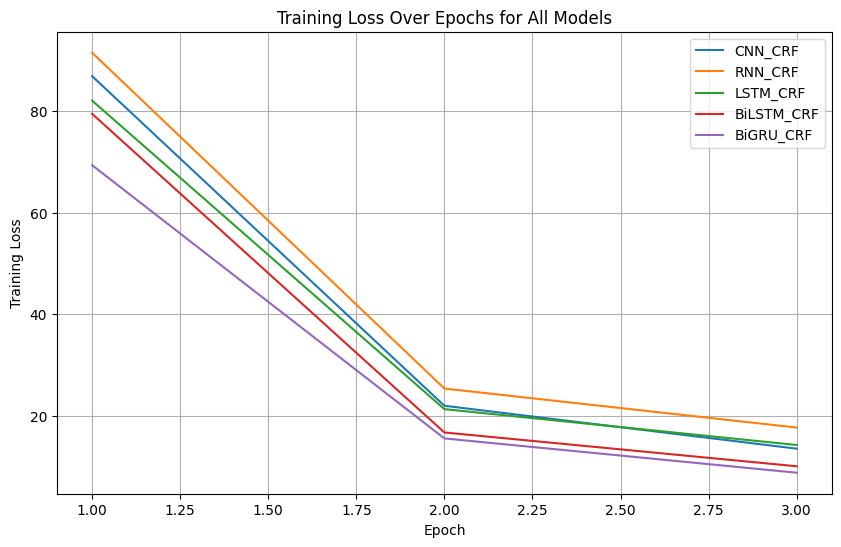

In [1]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from torchcrf import CRF
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score
import matplotlib.pyplot as plt

class MixedTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        boundary_idx = int(self.labels[idx])
        words = text.split()
        if len(words) > self.max_len - 2:
            if boundary_idx > self.max_len - 2:
                words = words[-(self.max_len - 2):]
                boundary_idx = 0
            else:
                words = words[:self.max_len - 2]
        word_labels = [0 if i <= boundary_idx else 1 for i in range(len(words))]
        truncated_text = " ".join(words)
        encoding = self.tokenizer(
            truncated_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            return_special_tokens_mask=True
        )
        special_tokens_mask = encoding['special_tokens_mask'][0]
        token_labels = []
        current_word_idx = 0
        for is_special in special_tokens_mask:
            if is_special:
                token_labels.append(-100)
            else:
                if current_word_idx < len(word_labels):
                    token_labels.append(word_labels[current_word_idx])
                    current_word_idx += 1
                else:
                    token_labels.append(-100)
        token_labels = token_labels[:self.max_len]
        if len(token_labels) < self.max_len:
            token_labels.extend([-100] * (self.max_len - len(token_labels)))
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(token_labels)
        }

class CNNCRFTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_labels, embedding_dim=768, dropout=0.3):
        super(CNNCRFTagger, self).__init__()
        self.num_labels = num_labels
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embed_dropout = nn.Dropout(dropout)
        self.conv = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.hidden2hidden = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout))
        self.hidden2tag = nn.Linear(hidden_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
        for name, param in self.named_parameters():
            if 'weight' in name:
                if len(param.shape) > 1:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.normal_(param, mean=0, std=0.01)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, input_ids, attention_mask, labels=None):
        embedded = self.embedding(input_ids)
        embedded = self.embed_dropout(embedded)
        embedded = embedded * attention_mask.unsqueeze(-1)
        embedded = embedded.permute(0, 2, 1)
        conv_out = self.conv(embedded)
        conv_out = self.relu(conv_out)
        conv_out = conv_out.permute(0, 2, 1)
        conv_out = self.layer_norm(conv_out)
        conv_out = self.hidden2hidden(conv_out)
        logits = self.hidden2tag(conv_out)
        if labels is not None:
            mask = attention_mask.bool()
            crf_labels = labels.clone()
            crf_labels[crf_labels == -100] = 0
            loss = -self.crf(logits, crf_labels, mask=mask, reduction='mean')
            return loss
        else:
            mask = attention_mask.bool()
            predictions = self.crf.decode(logits, mask=mask)
            padded_predictions = []
            for pred, mask_len in zip(predictions, attention_mask.sum(1).tolist()):
                pad_len = attention_mask.size(1) - len(pred)
                padded_pred = pred + [0] * pad_len
                padded_predictions.append(padded_pred)
            return torch.tensor(padded_predictions, device=input_ids.device)

class RNNCRFTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_labels, embedding_dim=768, num_layers=2, dropout=0.3):
        super(RNNCRFTagger, self).__init__()
        self.num_labels = num_labels
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embed_dropout = nn.Dropout(dropout)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.hidden2hidden = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout))
        self.hidden2tag = nn.Linear(hidden_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
        for name, param in self.named_parameters():
            if 'weight' in name:
                if len(param.shape) > 1:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.normal_(param, mean=0, std=0.01)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, input_ids, attention_mask, labels=None):
        embedded = self.embedding(input_ids)
        embedded = self.embed_dropout(embedded)
        embedded = embedded * attention_mask.unsqueeze(-1)
        rnn_out, _ = self.rnn(embedded)
        rnn_out = self.layer_norm(rnn_out)
        rnn_out = self.hidden2hidden(rnn_out)
        logits = self.hidden2tag(rnn_out)
        if labels is not None:
            mask = attention_mask.bool()
            crf_labels = labels.clone()
            crf_labels[crf_labels == -100] = 0
            loss = -self.crf(logits, crf_labels, mask=mask, reduction='mean')
            return loss
        else:
            mask = attention_mask.bool()
            predictions = self.crf.decode(logits, mask=mask)
            padded_predictions = []
            for pred, mask_len in zip(predictions, attention_mask.sum(1).tolist()):
                pad_len = attention_mask.size(1) - len(pred)
                padded_pred = pred + [0] * pad_len
                padded_predictions.append(padded_pred)
            return torch.tensor(padded_predictions, device=input_ids.device)

class LSTMCRFTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_labels, embedding_dim=768, num_layers=2, dropout=0.3):
        super(LSTMCRFTagger, self).__init__()
        self.num_labels = num_labels
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embed_dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.hidden2hidden = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout))
        self.hidden2tag = nn.Linear(hidden_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
        for name, param in self.named_parameters():
            if 'weight' in name:
                if len(param.shape) > 1:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.normal_(param, mean=0, std=0.01)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, input_ids, attention_mask, labels=None):
        embedded = self.embedding(input_ids)
        embedded = self.embed_dropout(embedded)
        embedded = embedded * attention_mask.unsqueeze(-1)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = self.hidden2hidden(lstm_out)
        logits = self.hidden2tag(lstm_out)
        if labels is not None:
            mask = attention_mask.bool()
            crf_labels = labels.clone()
            crf_labels[crf_labels == -100] = 0
            loss = -self.crf(logits, crf_labels, mask=mask, reduction='mean')
            return loss
        else:
            mask = attention_mask.bool()
            predictions = self.crf.decode(logits, mask=mask)
            padded_predictions = []
            for pred, mask_len in zip(predictions, attention_mask.sum(1).tolist()):
                pad_len = attention_mask.size(1) - len(pred)
                padded_pred = pred + [0] * pad_len
                padded_predictions.append(padded_pred)
            return torch.tensor(padded_predictions, device=input_ids.device)

class BiLSTMCRFTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_labels, embedding_dim=768, num_layers=2, dropout=0.3):
        super(BiLSTMCRFTagger, self).__init__()
        self.num_labels = num_labels
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embed_dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.hidden2hidden = nn.Sequential(nn.Linear(hidden_dim * 2, hidden_dim * 2), nn.ReLU(), nn.Dropout(dropout))
        self.hidden2tag = nn.Linear(hidden_dim * 2, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
        for name, param in self.named_parameters():
            if 'weight' in name:
                if len(param.shape) > 1:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.normal_(param, mean=0, std=0.01)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, input_ids, attention_mask, labels=None):
        embedded = self.embedding(input_ids)
        embedded = self.embed_dropout(embedded)
        embedded = embedded * attention_mask.unsqueeze(-1)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = self.hidden2hidden(lstm_out)
        logits = self.hidden2tag(lstm_out)
        if labels is not None:
            mask = attention_mask.bool()
            crf_labels = labels.clone()
            crf_labels[crf_labels == -100] = 0
            loss = -self.crf(logits, crf_labels, mask=mask, reduction='mean')
            return loss
        else:
            mask = attention_mask.bool()
            predictions = self.crf.decode(logits, mask=mask)
            padded_predictions = []
            for pred, mask_len in zip(predictions, attention_mask.sum(1).tolist()):
                pad_len = attention_mask.size(1) - len(pred)
                padded_pred = pred + [0] * pad_len
                padded_predictions.append(padded_pred)
            return torch.tensor(padded_predictions, device=input_ids.device)

class BiGRUCRFTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_labels, embedding_dim=768, num_layers=2, dropout=0.3):
        super(BiGRUCRFTagger, self).__init__()
        self.num_labels = num_labels
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embed_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.hidden2hidden = nn.Sequential(nn.Linear(hidden_dim * 2, hidden_dim * 2), nn.ReLU(), nn.Dropout(dropout))
        self.hidden2tag = nn.Linear(hidden_dim * 2, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
        for name, param in self.named_parameters():
            if 'weight' in name:
                if len(param.shape) > 1:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.normal_(param, mean=0, std=0.01)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, input_ids, attention_mask, labels=None):
        embedded = self.embedding(input_ids)
        embedded = self.embed_dropout(embedded)
        embedded = embedded * attention_mask.unsqueeze(-1)
        gru_out, _ = self.gru(embedded)
        gru_out = self.layer_norm(gru_out)
        gru_out = self.hidden2hidden(gru_out)
        logits = self.hidden2tag(gru_out)
        if labels is not None:
            mask = attention_mask.bool()
            crf_labels = labels.clone()
            crf_labels[crf_labels == -100] = 0
            loss = -self.crf(logits, crf_labels, mask=mask, reduction='mean')
            return loss
        else:
            mask = attention_mask.bool()
            predictions = self.crf.decode(logits, mask=mask)
            padded_predictions = []
            for pred, mask_len in zip(predictions, attention_mask.sum(1).tolist()):
                pad_len = attention_mask.size(1) - len(pred)
                padded_pred = pred + [0] * pad_len
                padded_predictions.append(padded_pred)
            return torch.tensor(padded_predictions, device=input_ids.device)

def train_model(model, data_loader, optimizer, scheduler, device, clip_value=1.0):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        loss = model(input_ids, attention_mask, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
        optimizer.step()
        if scheduler:
            scheduler.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate_model(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            predictions = model(input_ids, attention_mask)
            for pred_seq, label_seq, mask_seq in zip(predictions, labels, attention_mask):
                valid_indices = (mask_seq == 1) & (label_seq != -100)
                valid_pred = pred_seq[valid_indices].cpu().numpy()
                valid_label = label_seq[valid_indices].cpu().numpy()
                all_predictions.extend(valid_pred)
                all_labels.extend(valid_label)
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    absolute_errors = np.abs(all_predictions - all_labels)
    mae = np.mean(absolute_errors)
    std_dev = np.std(absolute_errors)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
    mcc = matthews_corrcoef(all_labels, all_predictions)
    kappa = cohen_kappa_score(all_labels, all_predictions)
    return accuracy, precision, recall, f1, mcc, mae, std_dev, kappa

def predict_boundary(model, text, tokenizer, max_len, device, model_type):
    model.eval()
    encoding = tokenizer(
        text,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
        return_special_tokens_mask=True
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    with torch.no_grad():
        embedded = model.embedding(input_ids)
        embedded = model.embed_dropout(embedded)
        embedded = embedded * attention_mask.unsqueeze(-1)
        if model_type == "CNN_CRF":
            embedded = embedded.permute(0, 2, 1)
            conv_out = model.conv(embedded)
            conv_out = model.relu(conv_out)
            conv_out = conv_out.permute(0, 2, 1)
            out = model.layer_norm(conv_out)
            out = model.hidden2hidden(out)
        elif model_type == "RNN_CRF":
            out, _ = model.rnn(embedded)
            out = model.layer_norm(out)
            out = model.hidden2hidden(out)
        elif model_type == "LSTM_CRF":
            out, _ = model.lstm(embedded)
            out = model.layer_norm(out)
            out = model.hidden2hidden(out)
        elif model_type == "BiLSTM_CRF":
            out, _ = model.lstm(embedded)
            out = model.layer_norm(out)
            out = model.hidden2hidden(out)
        elif model_type == "BiGRU_CRF":
            out, _ = model.gru(embedded)
            out = model.layer_norm(out)
            out = model.hidden2hidden(out)
        logits = model.hidden2tag(out)
        mask = attention_mask.bool()
        predictions = model.crf.decode(logits, mask=mask)
    pred_labels = predictions[0]
    boundary_index = next((i for i, label in enumerate(pred_labels) if label == 1), len(pred_labels))
    special_tokens_mask = encoding['special_tokens_mask'][0].tolist()
    actual_tokens = [i for i, is_special in enumerate(special_tokens_mask) if not is_special]
    if boundary_index < len(actual_tokens):
        boundary_index = actual_tokens[boundary_index]
    return boundary_index

MODEL_NAME = 'microsoft/deberta-v3-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = {
    'batch_size': 16,
    'learning_rate': 1e-3,
    'hidden_dim': 512,
    'embedding_dim': 768,
    'num_layers': 2,
    'dropout': 0.3,
    'epochs': 3,
    'max_len': 512,
    'weight_decay': 0.01,
    'gradient_clip': 1.0
}

train_df = pd.read_csv('sentence_train_data.csv')
dev_df = pd.read_csv('sentence_dev_data.csv')
test_df = pd.read_csv('sentence_test.csv')

train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()
dev_texts = dev_df["text"].tolist()
dev_labels = dev_df["label"].tolist()
test_texts = test_df["text"].tolist()
test_labels = test_df["label"].tolist()

train_dataset = MixedTextDataset(train_texts, train_labels, tokenizer, max_len=config['max_len'])
dev_dataset = MixedTextDataset(dev_texts, dev_labels, tokenizer, max_len=config['max_len'])
test_dataset = MixedTextDataset(test_texts, test_labels, tokenizer, max_len=config['max_len'])

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = tokenizer.vocab_size
num_labels = 2

models = [
    ("CNN_CRF", CNNCRFTagger),
    ("RNN_CRF", RNNCRFTagger),
    ("LSTM_CRF", LSTMCRFTagger),
    ("BiLSTM_CRF", BiLSTMCRFTagger),
    ("BiGRU_CRF", BiGRUCRFTagger)
]

best_kappa = -float('inf')
best_model_name = None
best_epoch = 0
results = []
all_train_losses = {}

for model_name, model_class in models:
    print(f"\nTraining {model_name}...")
    if model_name == "CNN_CRF":
        model = model_class(vocab_size, config['hidden_dim'], num_labels,
                            embedding_dim=config['embedding_dim'],
                            dropout=config['dropout']).to(device)
    else:
        model = model_class(vocab_size, config['hidden_dim'], num_labels,
                            embedding_dim=config['embedding_dim'],
                            num_layers=config['num_layers'],
                            dropout=config['dropout']).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    total_steps = len(train_loader) * config['epochs']
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['learning_rate'],
                                                   total_steps=total_steps, pct_start=0.1, anneal_strategy='cos')
    current_best_kappa = -float('inf')
    current_best_epoch = 0
    best_model_state = None
    train_losses = []
    val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'mcc': [], 'mae': [], 'std_dev': [], 'kappa': []}
    
    for epoch in range(config['epochs']):
        print(f"Epoch {epoch + 1}/{config['epochs']}")
        train_loss = train_model(model, train_loader, optimizer, scheduler, device, config['gradient_clip'])
        train_losses.append(train_loss)
        val_accuracy, val_precision, val_recall, val_f1, val_mcc, val_mae, val_std_dev, val_kappa = evaluate_model(model, dev_loader, device)
        val_metrics['accuracy'].append(val_accuracy)
        val_metrics['precision'].append(val_precision)
        val_metrics['recall'].append(val_recall)
        val_metrics['f1'].append(val_f1)
        val_metrics['mcc'].append(val_mcc)
        val_metrics['mae'].append(val_mae)
        val_metrics['std_dev'].append(val_std_dev)
        val_metrics['kappa'].append(val_kappa)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Metrics:")
        print(f"Accuracy: {val_accuracy:.4f}")
        print(f"Precision: {val_precision:.4f}")
        print(f"Recall: {val_recall:.4f}")
        print(f"F1 Score: {val_f1:.4f}")
        print(f"MCC: {val_mcc:.4f}")
        print(f"MAE: {val_mae:.2f}±{val_std_dev:.2f}")
        print(f"Kappa: {val_kappa:.4f}")
        
        if val_kappa > current_best_kappa:
            current_best_kappa = val_kappa
            current_best_epoch = epoch + 1
            best_model_state = model.state_dict()
        
        if val_kappa > best_kappa:
            best_kappa = val_kappa
            best_model_name = model_name
            best_epoch = epoch + 1
    
    all_train_losses[model_name] = train_losses
    print(f"Best {model_name} model at epoch {current_best_epoch} with Kappa Score: {current_best_kappa:.4f}")
    
    model.load_state_dict(best_model_state)
    model.eval()
    test_accuracy, test_precision, test_recall, test_f1, test_mcc, test_mae, test_std_dev, test_kappa = evaluate_model(model, test_loader, device)
    print(f"Test Results ({model_name}): Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, "
          f"F1 Score: {test_f1:.4f}, MCC: {test_mcc:.4f}, MAE: {test_mae:.2f}±{test_std_dev:.2f}, Kappa: {test_kappa:.4f}")
    
    test_df_copy = test_df.copy()
    test_df_copy["predicted_boundary"] = test_df_copy["text"].apply(
        lambda x: predict_boundary(model, x, tokenizer, max_len=config['max_len'], device=device, model_type=model_name)
    )
    difference = (test_df_copy['label'] - test_df_copy['predicted_boundary']).abs()
    boundary_mae = difference.mean()
    boundary_sd = difference.std()
    print(f"Boundary MAE ± SD ({model_name}): {boundary_mae:.4f} ± {boundary_sd:.4f}")
    
    results.append({
        'model_name': model_name,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_mcc': test_mcc,
        'test_mae': test_mae,
        'test_std_dev': test_std_dev,
        'test_kappa': test_kappa,
        'boundary_mae': boundary_mae,
        'boundary_sd': boundary_sd,
        'predictions': test_df_copy[['text', 'label', 'predicted_boundary']]
    })

plt.figure(figsize=(10, 6))
for model_name, losses in all_train_losses.items():
    plt.plot(range(1, config['epochs'] + 1), losses, label=model_name)
plt.title('Training Loss Over Epochs for All Models')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss_plot.png')

print(f"\nBest overall model: {best_model_name} at epoch {best_epoch} with Kappa Score: {best_kappa:.4f}")

for res in results:
    print(f"\nSummary for {res['model_name']}:")
    print(f"Test Accuracy: {res['test_accuracy']:.4f}")
    print(f"Test Precision: {res['test_precision']:.4f}")
    print(f"Test Recall: {res['test_recall']:.4f}")
    print(f"Test F1 Score: {res['test_f1']:.4f}")
    print(f"Test MCC: {res['test_mcc']:.4f}")
    print(f"Test MAE: {res['test_mae']:.2f}±{res['test_std_dev']:.2f}")
    print(f"Test Kappa: {res['test_kappa']:.4f}")
    print(f"Boundary MAE ± SD: {res['boundary_mae']:.4f} ± {res['boundary_sd']:.4f}")